## 1. Load Data

In [1]:
using TorusEvol
using Distributions
using TimerOutputs

chainX = from_pdb("1A3N", "A")
chainY = from_pdb("1MBN", "A")
X = data(chainX)
Y = data(chainY)

data(X)[2][isnan.(data(X)[2])] .= 0.0
data(Y)[2][isnan.(data(Y)[2])] .= 0.0

my_diff = jumping(WrappedDiffusion(-1.0, -0.8, 0.1, 0.1, 1.0, 1.0, 0.2), 10.0)
my_diff2 = jumping(WrappedDiffusion(-1.0, -0.8, 2.0, 2.0, 1.0, 1.0, 0.1), 10.0)

w = WAG_SubstitutionProcess
processes = [w w; my_diff my_diff2]
weights = [0.8, 0.2]
ξ = MixtureProductProcess(weights, processes)

t = 1.58
λ = 0.03; μ = 0.032; r = 0.3
align_model = TKF92([t], λ, μ, r)
pair_hmm = PairDataHMM(align_model, num_sites(X), num_sites(Y));
X = slice(X, :, 1:1)
Y = slice(Y, :, 1:1)

[ Info: Precompiling TorusEvol [4b860a26-b3bc-4b38-a9ed-83c1dc5d19b0]
[ Info: File exists: 1A3N
[ Info: File exists: 1MBN


ObservedData(
num sites: 153
num coords: 1
)

## 2. Inference Model

In [2]:
using Turing 
using ReverseDiff
#Turing.setadbackend(:reversediff)
Turing.setrdcache(true)
Turing.setadbackend(:forwarddiff)
Turing.setprogress!(true)

@model function pair_param_inference(X, Y; E=1)
    # Sample branch length a.k.a. time
    t ~ Exponential(1.0)
    
    
    # Sample alignment parameters 
    # todo - do this in a stand-alone submodel
    #λ_a ~ Exponential(0.01)
    λ_a ~ Uniform(0, 1.0)
    #seq_length ~ Exponential(100)
    seq_inv_length = 1 / 145
    μ_a = (seq_inv_length+1) * λ_a
    r_a ~ Uniform(0,1)
    align_model = TKF92([t], λ_a, μ_a, r_a)
    
    
    # Sample site-level evolutionary processes 
    
    # Sample the weight of each regime
    #proc_weights ~ Dirichlet(E, 1.0)
    proc_weights=[1.0]
    
    # Sample aminoacid substitution parameters
    # todo - construct custom substitution process
    sub_procs = reshape(fill(WAG_SubstitutionProcess, E), 1, E)
    
    # Sample dihedral angle evolution parameters
    #todo - do this in a stand-alone submodel
    μ_𝜙 = Vector(undef, E); μ_𝜓 = Vector(undef, E)
    σ_𝜙 = Vector(undef, E); σ_𝜓 = Vector(undef, E)
    for e ∈ 1:E 
        pp = 0
        #μ_𝜙[e] ~ Uniform(-π, π)
        #μ_𝜓[e] ~ Uniform(-π, π)
        #σ_𝜙[e] ~ Exponential(0.5)
        #σ_𝜓[e] ~ Exponential(0.5)
    end
    μ_𝜙 = fill(0.3, E); μ_𝜓 = fill(0.3, E)
    σ_𝜙 = fill(0.3, E); σ_𝜓 = fill(0.3, E)
    α_𝜙 = fill(1.0, E); α_𝜙 = fill(1.0, E); α_cov = fill(0.1, E)
    γ = fill(20.0, E)
    #diff_procs = reshape(jumping.(WrappedDiffusion.(μ_𝜙, μ_𝜓, σ_𝜙, σ_𝜓, α_𝜙, α_𝜙, α_cov), γ), 1, E)
    diff_procs = reshape(WrappedDiffusion.(μ_𝜙, μ_𝜓, σ_𝜙, σ_𝜓, α_𝜙, α_𝜙, α_cov), 1, E)
            
    # Construct mixture product process
    #ξ = MixtureProductProcess(proc_weights, vcat(sub_procs, diff_procs))
    ξ = MixtureProductProcess(proc_weights, sub_procs)

    # Observe X, Y by proxy of their joint probabilities 
    emission_lps = fulllogpdf(ξ, t, X, Y)
    pair_hmm = PairDataHMM(align_model, num_sites(X), num_sites(Y))
    Turing.@addlogprob! logpdf(pair_hmm, emission_lps)
end

[ Info: [Turing]: progress logging is enabled globally
[ Info: [AdvancedVI]: global PROGRESS is set as true


pair_param_inference (generic function with 2 methods)

In [3]:
using TorusEvol
using StatsPlots

model = pair_param_inference(X, Y)
alg = Gibbs(HMC(0.1, 5, :t), HMC(0.03, 10, :λ_a), HMC(0.2, 5, :μ_𝜙), HMC(0.2, 5, :μ_𝜓),
            HMC(0.03, 5, :r_a))

hmc1 = Gibbs(HMC(0.1, 5, :t), HMC(0.03, 5, :r_a), HMC(0.03, 5, :λ_a))
mh1 = Gibbs(MH(:t), MH(:μ_𝜙), MH(:μ_𝜓))
        
algmh = Gibbs(MH(:t), MH(:λ_a), MH(:μ_𝜙), MH(:μ_𝜓), MH(:r_a))
numsamples = 10
reset_timer!(to)
ch = sample(model, hmc1, numsamples)

Sampling: 100%|█████████████████████████████████████████| Time: 0:02:07


Chains MCMC chain (10×4×1 Array{Float64, 3}):

Iterations        = 1:1:10
Number of chains  = 1
Samples per chain = 10
Wall duration     = 176.82 seconds
Compute duration  = 176.82 seconds
parameters        = t, λ_a, r_a
internals         = lp

Summary Statistics
  parameters      mean       std      mcse   ess_bulk   ess_tail      rhat   e ⋯
      Symbol   Float64   Float64   Float64    Float64    Float64   Float64     ⋯

           t    2.5304    1.9147    0.8645     7.1732    10.0000    1.6048     ⋯
         λ_a    0.2611    0.0548    0.0269     4.2895    10.0000    1.5820     ⋯
         r_a    0.7777    0.0502    0.0265     3.9798    10.0000    2.0820     ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

           t    0.8092    1.3347    1.7677    3.0364    6.3936
         λ_a    0.1789    0.2191    0.2620    

In [4]:
print(to)

 ────────────────────────────────────────────────────────────────────────
                                Time                    Allocations      
                       ───────────────────────   ────────────────────────
   Tot / % measured:         220s /  10.4%           46.4GiB /  12.1%    

 Section       ncalls     time    %tot     avg     alloc    %tot      avg
 ────────────────────────────────────────────────────────────────────────
 logsumexp α    18.6M    10.3s   44.9%   556ns   2.65GiB   47.2%     153B
 jointlogpdf      214    9.15s   39.7%  42.7ms   2.34GiB   41.7%  11.2MiB
 statlogpdf       428    2.64s   11.5%  6.18ms    546MiB    9.5%  1.27MiB
 logsumexp        642    900ms    3.9%  1.40ms   93.4MiB    1.6%   149KiB
 ────────────────────────────────────────────────────────────────────────

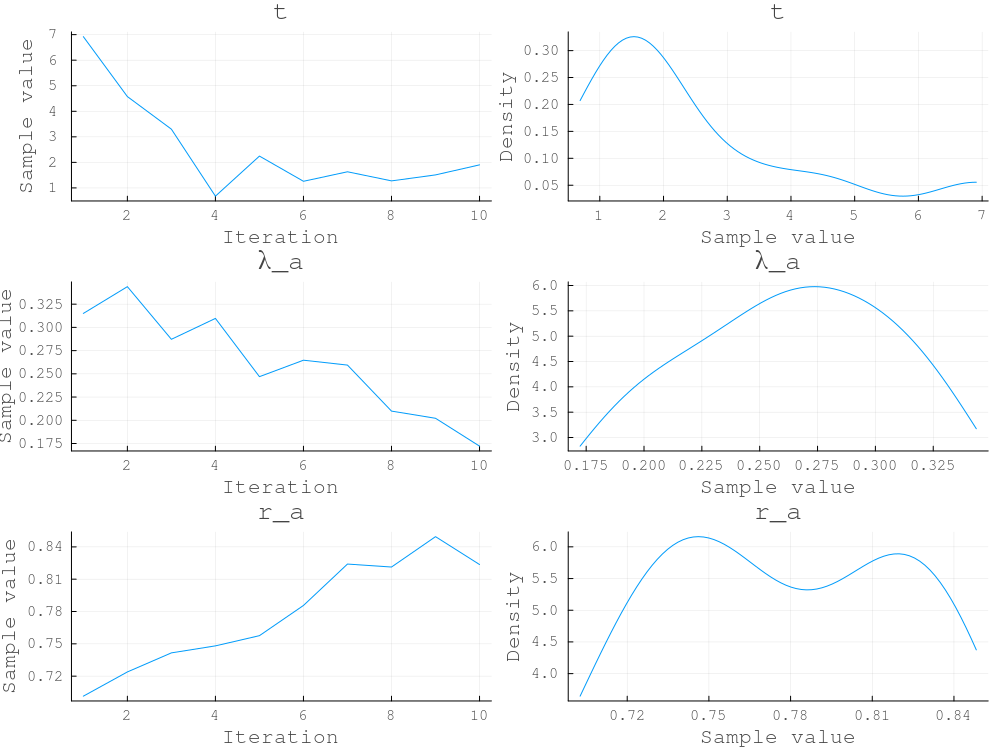

GKS: could not find font JuliaMono.ttf


In [5]:
p = plot(ch, fontfamily="JuliaMono")
#savefig(p, "images/pairinfer2mh.svg")

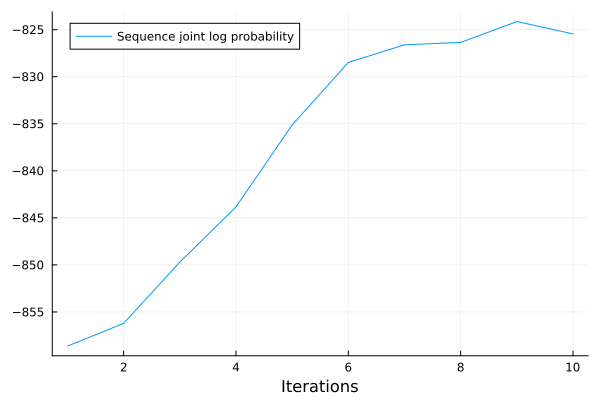

In [6]:
p = plot(get(ch, :lp).lp, xlabel="Iterations", label="Sequence joint log probability")
#savefig(p, "images/pairinferlp2mh.svg")